In [1]:
import os
import gc
import torch
from torchvision.transforms import v2
from torchvision import transforms
import torchvision
from copy import deepcopy as copy
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from umap_pytorch import PUMAP_DDP, load_pumap
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from torch.utils.data import DataLoader

from umap.umap_ import fuzzy_simplicial_set
from pynndescent import NNDescent
from sklearn.utils import check_random_state
from scipy.linalg import orth

import torch_pruning as tp

def dino_model():
    os.environ['TORCH_HOME'] = './'
    os.environ['TORCH_HUB'] = './'
    # DINOv2 vit-s (14) with registers
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
    # state = model.state_dict()
    # mymodel = vit_small(14, 4)
    # mymodel.load_state_dict(state)
    model.eval()

    return model.to('cpu')

def dino_transforms():
    return v2.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        transforms.Resize(size=(256, 256), antialias=True),
                        transforms.CenterCrop((224, 224)),
                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]
                                            ),
                    ]
                    )

DINOv2 = dino_model()
DINOv2_transform = dino_transforms()

import dinov2

/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/torch/hub.py:365: UserWarning: TORCH_HUB is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_HUB is deprecated, please use env TORCH_HOME instead')
Using cache found in ./hub/facebookresearch_dinov2_main
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jroth/Low-Rank

In [2]:


def get_activation(name):
    activations = []
    inputs = []
    def hook(model, input, output):
        activations.append(output.detach().clone()[:, 0].cpu().type(torch.float32))
        inputs.append(input[0].detach().clone()[:, 0].cpu().type(torch.float32))
    return hook, activations, inputs


def activationdist(network, test_loader, names, batches, dtype=torch.float32, silent=False):
    network = copy(network)
    network.eval().to(0)
    test_loss = 0
    correct = 0
    test_losses=[]

    dist_dict = {}
    in_dict = {}

    for name in names:
        hook, activations, inputs = get_activation(name)
        dist_dict[name] = activations
        in_dict[name] = inputs
        getattrrecur(network, name).register_forward_hook(hook)
    
    with torch.no_grad():
        for i, (data, target) in tqdm(enumerate(test_loader)):
            if i >= batches: 
                break
            output = network(data.to(0).type(dtype))

    return {k: torch.cat(dist_dict[k], 0) for k in dist_dict}, {k: torch.cat(in_dict[k], 0) for k in in_dict}

def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children
        

def getattrrecur(mod, s):
    s = s.split('.')
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split('.')
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def getlayernames(module):
    names = []

    for i, (name, mod) in enumerate(linearleaves(module)):
        names.append(name)

    return names


def batch_histogram(data_tensor, bins=10, bin_edges=None, interval=None):
    """
    computes a 1d histogram for each position in the last dimension of the tensor over all 
    values in that position over the flattened first k-1 dimensions, e.g activations of neurons
    in a layer over a batch of samples
    """

    data_tensor = data_tensor.flatten(0, -2)

    mind, maxd = (data_tensor.min(), data_tensor.max()) if interval is None else interval

    if bin_edges is None:
        bin_edges = (torch.arange(1, bins) - mind) / (maxd - mind)

    nc = len(bin_edges) + 1

    hist = torch.zeros((data_tensor.shape[-1], nc), dtype=data_tensor.dtype, device=data_tensor.device)

    hist[..., 0] += (data_tensor < bin_edges[0]).type(torch.int32).sum(0)

    for i in tqdm(range(len(bin_edges) - 1)):
        hist[..., i+1] += ((data_tensor >= bin_edges[i])*(data_tensor < bin_edges[i + 1])).type(torch.int32).sum(0)

    hist[..., -1] += (data_tensor >= bin_edges[-1]).type(torch.int32).sum(0)

    return hist, bin_edges


class Histogram:
    def __init__(self, bins, interval, density = False):
        self.bins = bins
        self.interval = interval
        self.histogram = None
        self.bin_edges = None

    def __call__(self, array):
        if self.histogram is None:
            self.histogram, self.bin_edges = batch_histogram(array, self.bins, interval=self.interval)
        else:
            hist, bin_edges = batch_histogram(array, self.bins, interval=self.interval)
            assert torch.equal(self.bin_edges, bin_edges), 'bin edges missmatch'
            self.histogram += hist

def hist_batch(hist, batch):
    hist(batch)

In [3]:
DINOv2 = dino_model()
DINOv2_transform = dino_transforms()

train_ds = torchvision.datasets.CIFAR10('./cifar10', train=True, transform=DINOv2_transform, download=True)
val_ds = torchvision.datasets.CIFAR10('./cifar10', train=False, transform=DINOv2_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=256)

names = getlayernames(DINOv2)
activations, inputs = activationdist(DINOv2, val_loader, names, 8)

Using cache found in ./hub/facebookresearch_dinov2_main


Files already downloaded and verified
Files already downloaded and verified


8it [00:05,  1.33it/s]


In [4]:
keys = [key for key in activations]
shapes = []

for key in keys:
    shapes.append(int(activations[key][0].shape[0]))

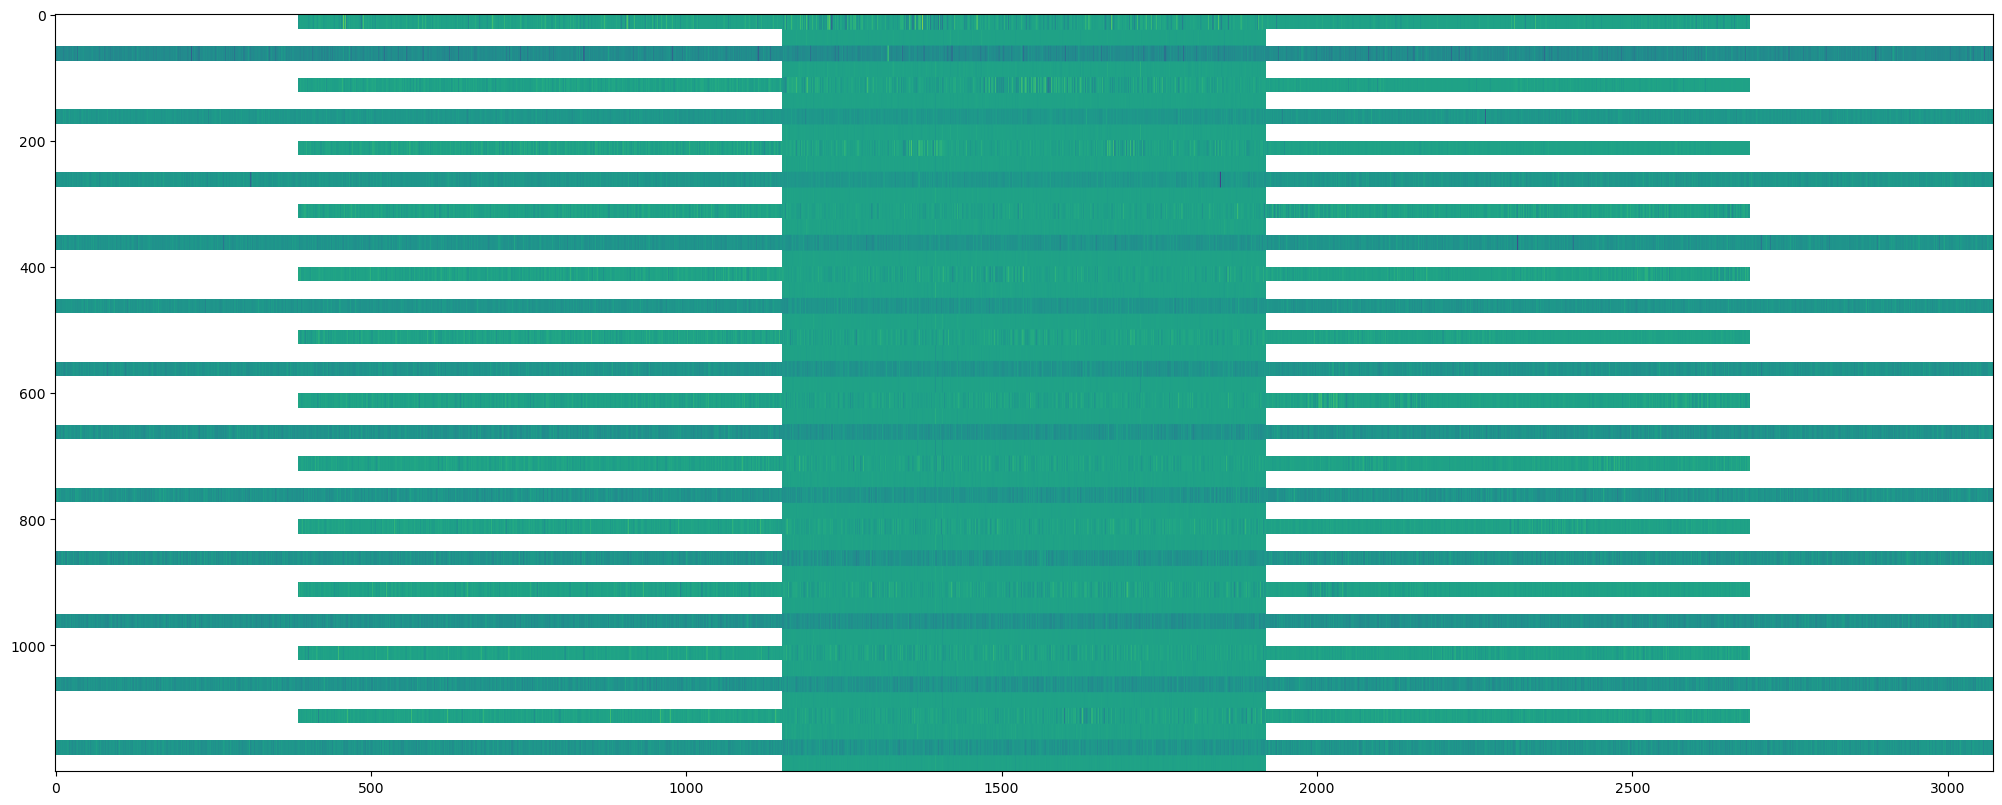

<Figure size 1920x1440 with 0 Axes>

In [5]:
fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.dpi'] = 300
maxres = max(shapes)
tmp = np.zeros((len(shapes)*25, maxres))

for i, (key, shape) in enumerate(zip(keys, shapes)):
    pad = (maxres - shape) // 2
    tmp[25*i:25*i+25, pad:shape+pad] = activations[key][i]
    if pad > 0:
        tmp[25*i:25*i+25, :pad] = np.nan
        tmp[25*i:25*i+25, -pad:] = np.nan

ax.imshow(tmp)

fig.set_figheight(10)
fig.set_figwidth(25)

plt.show()
plt.clf()

In [6]:
activation_histogram = Histogram(1000, (-30, 30))

activation_histogram(activations[keys[0]].to(0))

100%|██████████| 998/998 [00:00<00:00, 9787.97it/s]


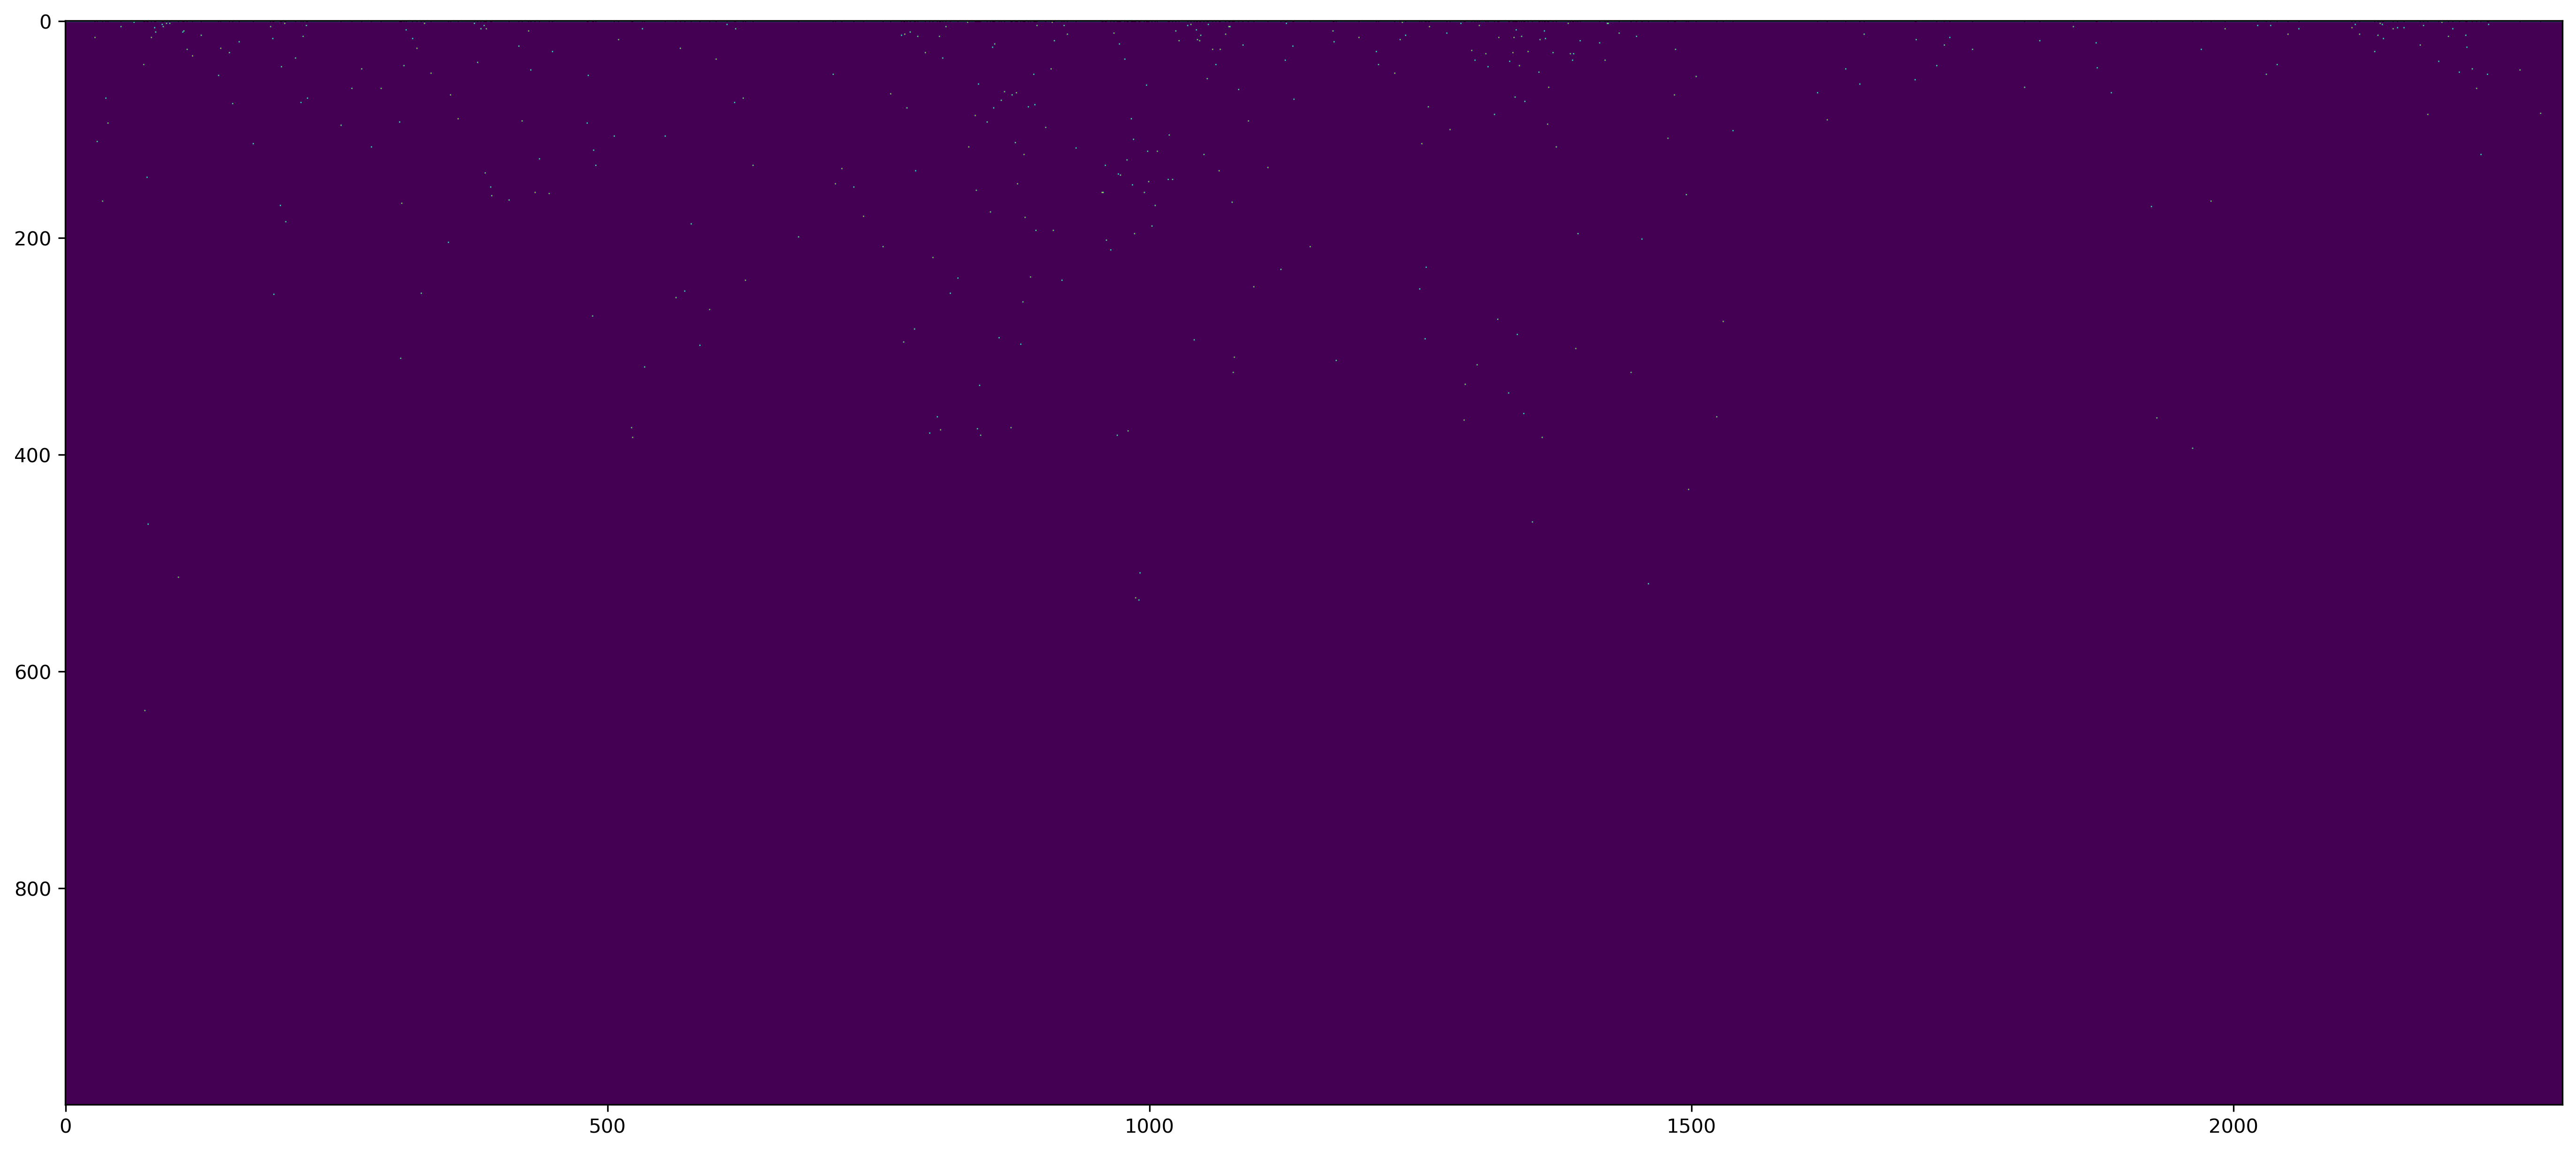

<Figure size 1920x1440 with 0 Axes>

In [7]:
hist = activation_histogram.histogram.cpu()

fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.dpi'] = 300
maxres = hist.shape[0]
tmp = np.zeros((hist.shape[1], maxres))

tmp = hist.permute(1, 0)

ax.imshow(tmp)

fig.set_figheight(10)
fig.set_figwidth(25)

plt.show()
plt.clf()

In [8]:
def get_orth(M, dim):
    rand_vec = (torch.tensor(np.random.rand(dim, 1)).type(torch.float32).to(0) - 0.5) * 2
    if M is None:
        return rand_vec
    # M = orth(M)
    M = torch.tensor(M).to(0)
    A = torch.hstack((M, rand_vec))
    b = torch.zeros(M.shape[1] + 1, dtype=torch.float32).to(0)
    b[-1] = 1
    return torch.linalg.lstsq(A.T, b, rcond=None)[0].unsqueeze(1)

@torch.no_grad()
def compute_largest_vector(network, in_features, orthogonal_to=None, iterations=100):

    noise = get_orth(orthogonal_to, in_features).T
    initial = noise.clone()

    for i in range(iterations):
        noise = torch.nn.functional.normalize(noise, 2, 1, 1e-12)
        noise = network(noise.float().to(0))

    return noise.T.cpu(), torch.nn.functional.normalize(initial.T.cpu())

def compute_pseudoeigen_vectors(network, in_features, iterations, components=-1):
    O = None
    V = None

    components = in_features if components <= 0 else components

    for i in tqdm(range(components)):
        value, initial = compute_largest_vector(network, in_features, O, iterations)
        if O is None:
            O = initial
            V = value
        else:
            O = torch.cat((O, initial), 1)
            V = torch.cat((V, value), 1)

    return V, O

def get_adversarial_directions(network, initializations = 1000, iterations=10):

    norms = []
    inits = []

    for ii in tqdm(range(initializations)):
        random = torch.rand((1, 768)).to(0)
        random.requires_grad = True

        for i in range(iterations):
            out = network(random)
            (out * out).sum().backward()
            with torch.no_grad():
                random_grad = random.grad.detach().clone()
                random = torch.nn.functional.normalize(random)
                random -= random_grad

            random.requires_grad = True

        inits.append(torch.nn.functional.normalize(random)), norms.append(random.norm())

    return torch.cat(inits, 0), norms

def find_power_directions(layer, powers=10, max_iters=128):
    layers = [layer]
    dirs = []
    for i in range(powers):
        network = torch.nn.Sequential(*layers)
        directions, norms = get_adversarial_directions(network, 1000, min(10**(i+1), max_iters))
        ord_i = orth(directions.detach().cpu().T, rcond=1e-4)
        dirs.append(ord_i)
        layers.append(layer)
    return np.concatenate(dirs, -1)

def get_activation_mlp(name):
    activations = []
    inputs = []
    def hook(model, input, output):
        activations.append(output.detach().clone().cpu().type(torch.float32))
        inputs.append(input[0].detach().clone().cpu().type(torch.float32))

    return hook, activations, inputs

def activation_input_batch(network, batch, dtype=torch.float32):
    network = copy(network)
    network.eval().to(0)

    dist_dict = {}
    in_dict = {}

    for name in getlayernames(network):
        hook, activations, inputs = get_activation_mlp(name)
        dist_dict[name] = activations
        in_dict[name] = inputs
        getattrrecur(network, name).register_forward_hook(hook)
    
    output = network(batch.to(0).type(dtype)).detach().cpu()

    return_in_dict = {k: torch.cat(in_dict[k], 0) for k in in_dict}
    return_in_dict.update({'out': output})

    return {k: torch.cat(dist_dict[k], 0) for k in dist_dict}, return_in_dict

class LinearProbe(torch.nn.Module):
    def __init__(self, module, in_dim=768, n_classes=10):
        super().__init__()
        self.m = module
        self.linear = torch.nn.Linear(in_dim, n_classes)
    
    def forward(self, x):
        x = self.m(x).detach()
        return self.linear(x) * 100
    
class GradientLinearProbe(torch.nn.Module):
    def __init__(self, probe):
        super().__init__()
        self.m = probe.m
        self.linear = probe.linear
    
    def forward(self, x):
        x = self.m(x)
        return self.linear(x) * 100
    
def train(model, optimizer, loader):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))
        optimizer.zero_grad()
        l = loss(out, y.to(0))
        l.backward()
        optimizer.step()

def test(network, test_loader, dtype=torch.float32, silent=False):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    test_losses=[]
    
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0).type(dtype))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        if not silent:
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
            
    if silent:
        return 100. * correct / len(test_loader.dataset) 


In [9]:
from sklearn.decomposition import PCA
pca = PCA(256)

batches = []

for i, batch in enumerate(train_loader):
    if i == 16:
        break
    batches.append(batch[0])

batches = torch.cat(batches, 0)
flat_batches = batches.flatten(1)

pca.fit(flat_batches)
flat_batches.shape, pca.components_.shape

(torch.Size([4096, 150528]), (256, 150528))

In [10]:
input_components = torch.tensor(pca.components_ + pca.mean_[None, :]).unflatten(1, (3, 224, 224))
input_components.shape

torch.Size([256, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


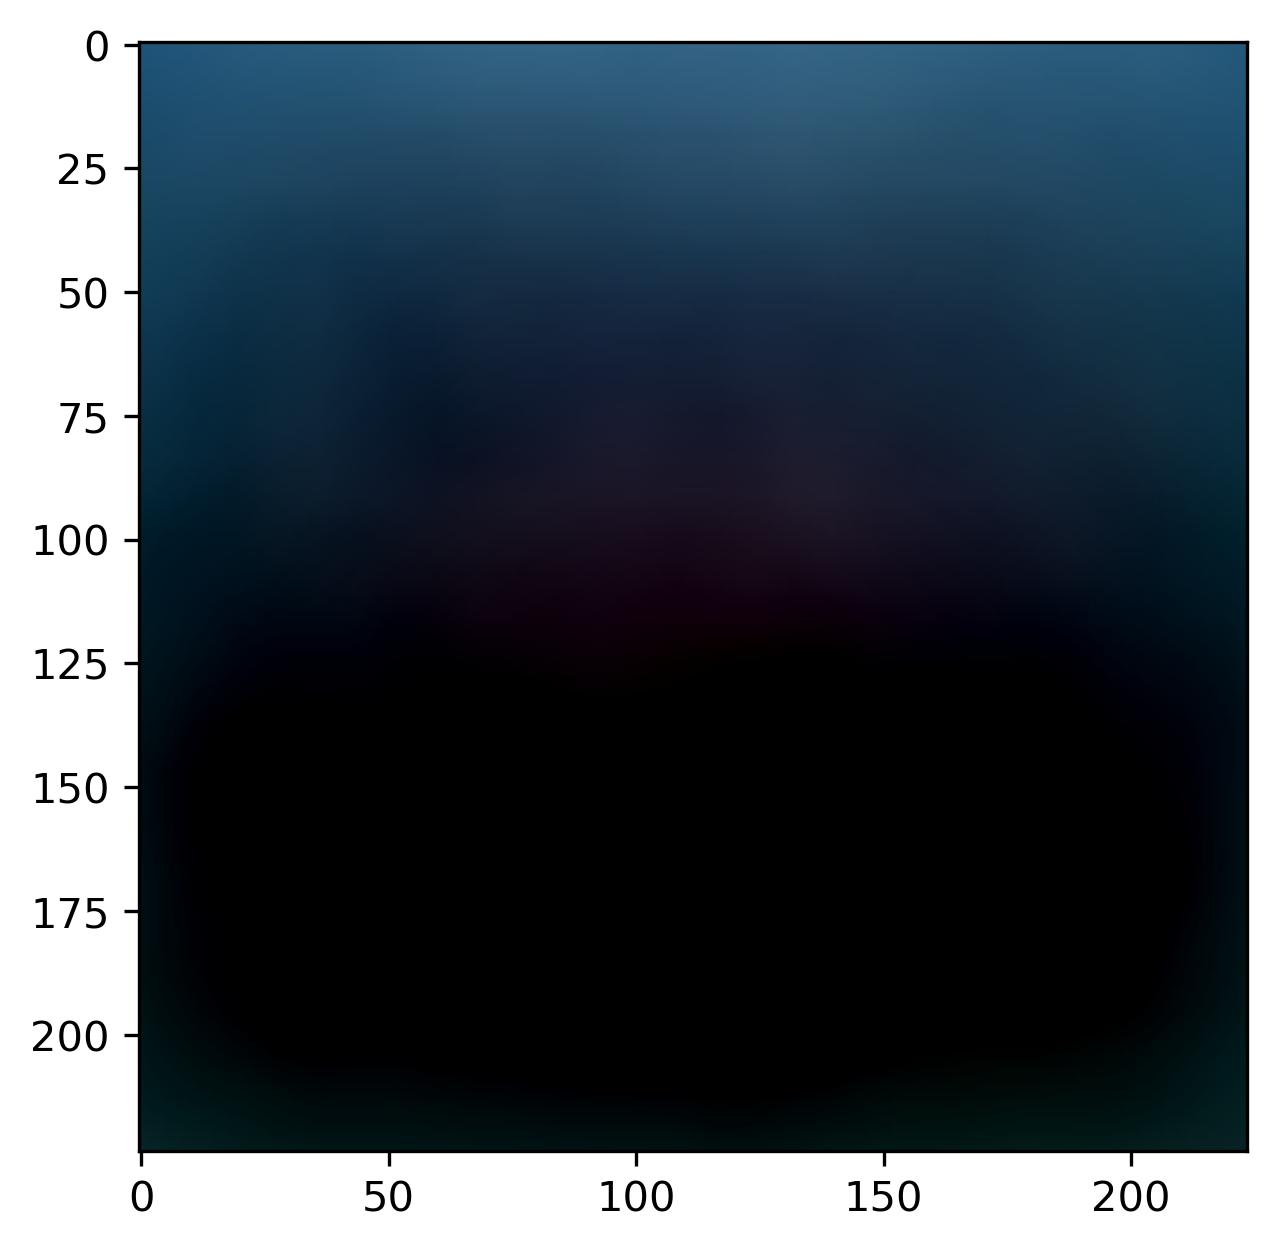

In [11]:
plt.imshow(input_components[0].permute(1,2,0))

In [12]:
def activation_graph(network, batch, dtype=torch.float32):
    network = copy(network)
    network.eval().to(0)

    dist_dict = {}
    in_dict = {}

    for name in getlayernames(network):
        hook, activations, inputs = get_activation(name)
        submod = getattrrecur(network, name)
        submod.register_forward_hook(hook)
        dist_dict[name] = activations
        in_dict[name] = inputs
    
    with torch.no_grad():
        output = network(batch.to(0).type(dtype)).detach().cpu()

    return_in_dict = {k: torch.cat(in_dict[k], 0) for k in in_dict}
    return_in_dict.update({'out': output})

    return {k: torch.cat(dist_dict[k], 0) for k in dist_dict}, return_in_dict


def remove_unimpactful_neurons(module, inputs):
    lipschitz = torch.linalg.vector_norm(inputs['out'], dim=-1)
    importance_weight = torch.diag(torch.tensor(pca.explained_variance_ratio_)) @ torch.diag(lipschitz)

    submods = [getattrrecur(DINOv2, name) for name in names]
    weights = [submod.weight for submod in submods]
    biases = [submod.bias for submod in submods]

    importances = {name: (((submod.weight.cpu() @ inputs_nodes[name].T) + submod.bias.unsqueeze(1).cpu()) @ importance_weight).detach().relu().mean(-1) for submod, name in zip(submods, names)}

    for name, name_previous in zip(names, names[1:]):
        important_neurons = torch.arange(len(importances[name]))[importances[name] > importances[name].mean()]
        unimportant_neurons = torch.arange(len(importances[name]))[importances[name] <= importances[name].mean()]

        # get the layer producing the activations
        layer_previous = copy(getattrrecur(module, name_previous)).to(0)
        # the layer that is recieving activations
        layer = copy(getattrrecur(module, name)).to(0)

        weight_residual = torch.zeros_like(layer.weight.data.T[important_neurons].T)

        # for each unimportant neuron we construct its approximation from the important ones
        for neuron_i in unimportant_neurons:
            # TODO: check shapes

            # the activations we are keeping
            A = inputs_nodes[name_previous][:, important_neurons]
            # one of those which we are discarding
            B = inputs_nodes[name_previous][:, neuron_i]

            # the least squares solution tells us what to multiply by the weight for the unimportant activation and then add to the input weights of the corresponding neuron.
            (soln, residuals, rank, singular_values) = torch.linalg.lstsq(torch.cat((A, torch.ones(A.shape[0], 1)), -1), B)
            soln_weight = soln[:-1]
            soln_bias = soln[-1]

            # TODO: continue...
            # TODO: figure out how to include bias (multiply by input weight of discarded input?)

            # layer.weight.data.T[neuron_i]
        
        # the weights corresponding to the inputs that were removed
        # layer.weight.data.T[unimportant_neurons]

        # alter the weight assignment
        layer_previous.weight.data = layer_previous.weight.data[important_neurons]
        layer.weight.data = layer.weight.data.T[important_neurons].T + weight_residual
        layer_previous.bias.data = layer_previous.bias.data[important_neurons]

        # replace those layers within the module
        setattrrecur(module, name_previous, layer_previous)
        setattrrecur(module, name, layer)

In [13]:
DINOv2 = dino_model().to(0)

names = getlayernames(DINOv2)

/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/torch/hub.py:365: UserWarning: TORCH_HUB is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_HUB is deprecated, please use env TORCH_HOME instead')
Using cache found in ./hub/facebookresearch_dinov2_main


In [14]:
DINOv2 = dino_model()
train_ds = torchvision.datasets.CIFAR10('./cifar', True, transform = DINOv2_transform, download = True)
val_ds = torchvision.datasets.CIFAR10('./cifar', False, transform = DINOv2_transform, download = True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64)

model = LinearProbe(DINOv2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using cache found in ./hub/facebookresearch_dinov2_main


Files already downloaded and verified
Files already downloaded and verified


In [15]:
for epoch in range(1):
    train(model.to(0), optimizer, train_loader)
    gc.collect()
test(model, val_loader)

0it [00:00, ?it/s]

782it [01:55,  6.77it/s]



Test set: Avg. loss: 0.0304, Accuracy: 9677/10000 (97%)



In [16]:
import torch.nn.functional as F
# Here we re-implement the forward function of timm.models.vision_transformer.Attention
# as the original forward function requires the input and output channels to be identical.
def forward(self, x):
    """https://github.com/huggingface/pytorch-image-models/blob/054c763fcaa7d241564439ae05fbe919ed85e614/timm/models/vision_transformer.py#L79"""
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)


    q = q * self.scale
    attn = q @ k.transpose(-2, -1)
    attn = attn.softmax(dim=-1)
    attn = self.attn_drop(attn)
    x = attn @ v

    x = x.transpose(1, 2).reshape(B, N, -1) # original implementation: x = x.transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x


In [17]:
def test_compression(model, val_loader, imp):

    example_inputs = torch.randn(1, 3, 224, 224)

    model.to('cpu')

    model = GradientLinearProbe(model)

    base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)

    num_heads = {}
    ignored_layers = [model.linear]
    for m in model.modules():
        if isinstance(m, dinov2.layers.attention.Attention):
            m.forward = forward.__get__(m, dinov2.layers.attention.Attention) # https://stackoverflow.com/questions/50599045/python-replacing-a-function-within-a-class-of-a-module
            num_heads[m.qkv] = m.num_heads 

        #if isinstance(m, dinov2.layers.mlp.Mlp): 
        #    ignored_layers.append(m.fc2) # only prune the internal layers of FFN & Attention

    pruner = tp.pruner.MetaPruner( # We can always choose MetaPruner if sparse training is not required.
        model,
        example_inputs,
        importance=imp,
        num_heads = num_heads,
        pruning_ratio=0.001, # error will occur if this is incorrectly set.
        # pruning_ratio_dict = {model.conv1: 0.2, model.layer2: 0.8}, # customized pruning ratios for layers or blocks
        ignored_layers=ignored_layers,
        #customized_pruners={PatchEmbed:PatchEmbedPruner()},
        root_module_types=(torch.nn.Linear, torch.nn.LayerNorm),
        prune_num_heads=False, # reduce num_heads by pruning entire heads (default: False)
        prune_head_dims=True, # reduce head_dim by pruning featrues dims of each head (default: True)
        head_pruning_ratio=0.5, #args.head_pruning_ratio, # remove 50% heads, only works when prune_num_heads=True (default: 0.0)
        round_to=2,
        global_pruning=True,
        isomorphic=False,
    )

    for i, g in enumerate(pruner.step(interactive=True)):
        g.prune()

    # Modify the attention head size and all head size aftering pruning
    """
    head_id = 0
    for m in model.modules():
        if isinstance(m, dinov2.layers.attention.Attention):
            print("Head #%d"%head_id)
            print("[Before Pruning] Num Heads: %d, Head Dim: %d =>"%(m.num_heads, m.head_dim))
            m.num_heads = pruner.num_heads[m.qkv]
            m.head_dim = m.qkv.out_features // (3 * m.num_heads)
            print("[After Pruning] Num Heads: %d, Head Dim: %d"%(m.num_heads, m.head_dim))
            print()
            head_id+=1
    """
    final_macs, final_nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(f"MACs: {base_macs/1e9} G -> {final_macs/1e9} G, #Params: {base_nparams/1e6} M -> {final_nparams/1e6} M")

    test(model, val_loader)

    return model

In [18]:
from torch import nn
import typing
from torch_pruning import function
from torch_pruning.dependency import Group

example_inputs = torch.randn(1, 3, 224, 224)

model_copy = copy(model)

model_copy.to('cpu')

model_copy = GradientLinearProbe(model_copy)

activations_nodes, inputs_nodes = activation_graph(copy(model), input_components)

lipschitz = torch.linalg.vector_norm(inputs_nodes['out'], dim=-1).float()
importance_weight = torch.diag(torch.tensor(pca.explained_variance_ratio_)).float() @ torch.diag(lipschitz)

layers_to_names = {layer: name for name, layer in model_copy.named_modules()}

class MyPCAImportance(tp.importance.Importance):
    def __call__(self, group, **kwargs):
        #note that we have multiple BNs in a group, 
        # we store layer-wise scores in a list and then reduce them to get the final results
        linear_layers = [] # (num_bns, num_channels) 
        # 1. iterate the group to estimate importance
        for i, (dep, idxs) in enumerate(group):
            layer = dep.layer
            if isinstance(layer, (torch.nn.Linear)):
                linear_layers.append(layer)

        if len(linear_layers) == 0: 
            print('none')
            # return None # return None if the group contains no Linear layer

        # 2. reduce your group importance to a 1-D score vector. Here we use the average score across layers.

        return ((inputs_nodes[layers_to_names[linear_layers[-1]]].T) @ importance_weight).detach().mean(-1) # (num_channels, )
    

class GroupNormImportance(tp.importance.Importance):
    """ A general implementation of magnitude importance. By default, it calculates the group L2-norm for each channel/dim.
        It supports several variants like:
            - Standard L1-norm of the first layer in a group: MagnitudeImportance(p=1, normalizer=None, group_reduction="first")
            - Group L1-Norm: MagnitudeImportance(p=1, normalizer=None, group_reduction="mean")
            - BN Scaling Factor: MagnitudeImportance(p=1, normalizer=None, group_reduction="mean", target_types=[nn.modules.batchnorm._BatchNorm])

        Args:
            * p (int): the norm degree. Default: 2
            * group_reduction (str): the reduction method for group importance. Default: "mean"
            * normalizer (str): the normalization method for group importance. Default: "mean"
            * target_types (list): the target types for importance calculation. Default: [nn.modules.conv._ConvNd, nn.Linear, nn.modules.batchnorm._BatchNorm]

        Example:
    
            It accepts a group as inputs, and return a 1-D tensor with the same length as the number of channels.
            All groups must be pruned simultaneously and thus their importance should be accumulated across channel groups.
            
            ```python
                DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224)) 
                group = DG.get_pruning_group( model.conv1, tp.prune_conv_out_channels, idxs=[2, 6, 9] )    
                scorer = GroupNormImportance()    
                imp_score = scorer(group)    
                #imp_score is a 1-D tensor with length 3 for channels [2, 6, 9]  
                min_score = imp_score.min() 
            ``` 
    """
    def __init__(self, 
                 p: int=2, 
                 group_reduction: str="mean", 
                 normalizer: str='mean', 
                 bias=False,
                 target_types:list=[nn.modules.conv._ConvNd, nn.Linear, nn.modules.batchnorm._BatchNorm, nn.LayerNorm]):
        self.p = p
        self.group_reduction = group_reduction
        self.normalizer = normalizer
        self.target_types = target_types
        self.bias = bias

    def _lamp(self, scores): # Layer-adaptive Sparsity for the Magnitude-based Pruning
        """
        Normalizing scheme for LAMP.
        """
        # sort scores in an ascending order
        sorted_scores,sorted_idx = scores.view(-1).sort(descending=False)
        # compute cumulative sum
        scores_cumsum_temp = sorted_scores.cumsum(dim=0)
        scores_cumsum = torch.zeros(scores_cumsum_temp.shape,device=scores.device)
        scores_cumsum[1:] = scores_cumsum_temp[:len(scores_cumsum_temp)-1]
        # normalize by cumulative sum
        sorted_scores /= (scores.sum() - scores_cumsum)
        # tidy up and output
        new_scores = torch.zeros(scores_cumsum.shape,device=scores.device)
        new_scores[sorted_idx] = sorted_scores
        
        return new_scores.view(scores.shape)
    
    def _normalize(self, group_importance, normalizer):
        if normalizer is None:
            return group_importance
        elif isinstance(normalizer, typing.Callable):
            return normalizer(group_importance)
        elif normalizer == "sum":
            return group_importance / group_importance.sum()
        elif normalizer == "standarization":
            return (group_importance - group_importance.min()) / (group_importance.max() - group_importance.min()+1e-8)
        elif normalizer == "mean":
            return group_importance / group_importance.mean()
        elif normalizer == "max":
            return group_importance / group_importance.max()
        elif normalizer == 'gaussian':
            return (group_importance - group_importance.mean()) / (group_importance.std()+1e-8)
        elif normalizer.startswith('sentinel'): # normalize the score with the k-th smallest element. e.g. sentinel_0.5 means median normalization
            sentinel = float(normalizer.split('_')[1]) * len(group_importance)
            sentinel = torch.argsort(group_importance, dim=0, descending=False)[int(sentinel)]
            return group_importance / (group_importance[sentinel]+1e-8)
        elif normalizer=='lamp':
            return self._lamp(group_importance)
        else:
            raise NotImplementedError

    def _reduce(self, group_imp: typing.List[torch.Tensor], group_idxs: typing.List[typing.List[int]]):
        if len(group_imp) == 0: return group_imp
        if self.group_reduction == 'prod':
            reduced_imp = torch.ones_like(group_imp[0])
        elif self.group_reduction == 'max':
            reduced_imp = torch.ones_like(group_imp[0]) * -99999
        else:
            reduced_imp = torch.zeros_like(group_imp[0])

        for i, (imp, root_idxs) in enumerate(zip(group_imp, group_idxs)):
            imp = imp.to(reduced_imp.device)
            if self.group_reduction == "sum" or self.group_reduction == "mean":
                reduced_imp.scatter_add_(0, torch.tensor(root_idxs, device=imp.device), imp) # accumulated importance
            elif self.group_reduction == "max": # keep the max importance
                selected_imp = torch.index_select(reduced_imp, 0, torch.tensor(root_idxs, device=imp.device))
                selected_imp = torch.maximum(input=selected_imp, other=imp)
                reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), selected_imp)
            elif self.group_reduction == "prod": # product of importance
                selected_imp = torch.index_select(reduced_imp, 0, torch.tensor(root_idxs, device=imp.device))
                torch.mul(selected_imp, imp, out=selected_imp)
                reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), selected_imp)
            elif self.group_reduction == 'first':
                if i == 0:
                    reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), imp)
            elif self.group_reduction == 'gate':
                if i == len(group_imp)-1:
                    reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), imp)
            elif self.group_reduction is None:
                reduced_imp = torch.stack(group_imp, dim=0) # no reduction
            else:
                raise NotImplementedError
        
        if self.group_reduction == "mean":
            reduced_imp /= len(group_imp)
        return reduced_imp
    
    @torch.no_grad()
    def __call__(self, group: Group):
        group_imp = []
        group_idxs = []
        group_layers = []
        # Iterate over all groups and estimate group importance
        for i, (dep, idxs) in enumerate(group):
            layer = dep.layer
            if isinstance(layer, torch.nn.Linear):
                group_layers.append(layer)
            prune_fn = dep.pruning_fn
            root_idxs = group[i].root_idxs
            if not isinstance(layer, tuple(self.target_types)):
                continue
            ####################
            # Conv/Linear Output
            ####################
            if prune_fn in [
                function.prune_conv_out_channels,
                function.prune_linear_out_channels,
            ]:
                if hasattr(layer, "transposed") and layer.transposed:
                    w = layer.weight.data.transpose(1, 0)[idxs].flatten(1)
                else:
                    w = layer.weight.data[idxs].flatten(1)
                local_imp = w.abs().pow(self.p).sum(1)
                group_imp.append(local_imp)
                group_idxs.append(root_idxs)

                if self.bias and layer.bias is not None:
                    local_imp = layer.bias.data[idxs].abs().pow(self.p)
                    group_imp.append(local_imp)
                    group_idxs.append(root_idxs)

            ####################
            # Conv/Linear Input
            ####################
            elif prune_fn in [
                function.prune_conv_in_channels,
                function.prune_linear_in_channels,
            ]:
                if hasattr(layer, "transposed") and layer.transposed:
                    w = (layer.weight.data).flatten(1)
                else:
                    w = (layer.weight.data).transpose(0, 1).flatten(1)
                local_imp = w.abs().pow(self.p).sum(1)

                # repeat importance for group convolutions
                if prune_fn == function.prune_conv_in_channels and layer.groups != layer.in_channels and layer.groups != 1:
                    local_imp = local_imp.repeat(layer.groups)
                
                local_imp = local_imp[idxs]
                group_imp.append(local_imp)
                group_idxs.append(root_idxs)

            ####################
            # BatchNorm
            ####################
            elif prune_fn == function.prune_batchnorm_out_channels:
                # regularize BN
                if layer.affine:
                    w = layer.weight.data[idxs]
                    local_imp = w.abs().pow(self.p)
                    group_imp.append(local_imp)
                    group_idxs.append(root_idxs)

                    if self.bias and layer.bias is not None:
                        local_imp = layer.bias.data[idxs].abs().pow(self.p)
                        group_imp.append(local_imp)
                        group_idxs.append(root_idxs)
            ####################
            # LayerNorm
            ####################
            elif prune_fn == function.prune_layernorm_out_channels:

                if layer.elementwise_affine:
                    w = layer.weight.data[idxs]
                    local_imp = w.abs().pow(self.p)
                    group_imp.append(local_imp)
                    group_idxs.append(root_idxs)

                    if self.bias and layer.bias is not None:
                        local_imp = layer.bias.data[idxs].abs().pow(self.p)
                        group_imp.append(local_imp)
                        group_idxs.append(root_idxs)

        if len(group_imp) == 0: # skip groups without parameterized layers
            return None
        
        group_imp = self._reduce(group_imp, group_idxs)
        group_imp = self._normalize(group_imp, self.normalizer)

        return group_imp
    
pca_imp = MyPCAImportance()

gn_imp = GroupNormImportance(p=2, target_types=(torch.nn.Linear, ))

In [19]:
compressed = test_compression(model_copy, val_loader, pca_imp)

/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/torch_pruning/dependency.py:697: UserWarning: Unwrapped parameters detected: ['m.blocks.4.ls1.gamma', 'm.blocks.4.ls2.gamma', 'm.blocks.5.ls1.gamma', 'm.blocks.7.ls1.gamma', 'm.blocks.10.ls1.gamma', 'm.blocks.9.ls1.gamma', 'm.blocks.9.ls2.gamma', 'm.blocks.10.ls2.gamma', 'm.mask_token', 'm.blocks.1.ls1.gamma', 'm.blocks.3.ls1.gamma', 'm.blocks.6.ls2.gamma', 'm.blocks.11.ls2.gamma', 'm.blocks.8.ls1.gamma', 'm.blocks.11.ls1.gamma', 'm.cls_token', 'm.blocks.0.ls2.gamma', 'm.blocks.6.ls1.gamma', 'm.blocks.0.ls1.gamma', 'm.pos_embed', 'm.register_tokens', 'm.blocks.2.ls2.gamma', 'm.blocks.1.ls2.gamma', 'm.blocks.3.ls2.gamma', 'm.blocks.5.ls2.gamma', 'm.blocks.7.ls2.gamma', 'm.blocks.2.ls1.gamma', 'm.blocks.8.ls2.gamma'].
 Torch-Pruning will prune the last non-singleton dimension of these parameters. If you wish to change this behavior, please provide an unwrapped_parameters argument.
  warnings.warn(warning_str)


RuntimeError: shape '[1, 261, 3, 12, 64]' is invalid for input of size 582552

In [ ]:
compressed = test_compression(copy(model), val_loader, gn_imp)

/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/torch_pruning/dependency.py:697: UserWarning: Unwrapped parameters detected: ['m.cls_token', 'm.blocks.3.ls1.gamma', 'm.blocks.3.ls2.gamma', 'm.blocks.8.ls1.gamma', 'm.register_tokens', 'm.blocks.1.ls2.gamma', 'm.blocks.5.ls2.gamma', 'm.blocks.6.ls2.gamma', 'm.blocks.9.ls1.gamma', 'm.mask_token', 'm.blocks.10.ls2.gamma', 'm.blocks.9.ls2.gamma', 'm.blocks.0.ls1.gamma', 'm.blocks.1.ls1.gamma', 'm.blocks.2.ls2.gamma', 'm.blocks.7.ls1.gamma', 'm.blocks.11.ls2.gamma', 'm.pos_embed', 'm.blocks.5.ls1.gamma', 'm.blocks.7.ls2.gamma', 'm.blocks.10.ls1.gamma', 'm.blocks.2.ls1.gamma', 'm.blocks.4.ls1.gamma', 'm.blocks.4.ls2.gamma', 'm.blocks.6.ls1.gamma', 'm.blocks.0.ls2.gamma', 'm.blocks.8.ls2.gamma', 'm.blocks.11.ls1.gamma'].
 Torch-Pruning will prune the last non-singleton dimension of these parameters. If you wish to change this behavior, please provide an unwrapped_parameters argument.
  warnings.warn(warning_str)


MACs: 22.303481866 G -> 22.28663323 G, #Params: 86.591242 M -> 86.526688 M

Test set: Avg. loss: 0.0298, Accuracy: 9687/10000 (97%)

